# Relax and hold steady - Stokes Flow in vorticity - streamfunction formulation

Dans ce notebook, nous allons tenter de simuler un écoulement de Stokes dans une cavité carrée en résolvant l'équation de Navier-Stokes numériquement, en utilisant la formulation vorticité - fonction de courant.
Le modèle de l'écoulement de Stokes prend son sens pour des écoulement dominé par les forces visqueuses à nombre de Reynolds $<<1$.

L'équation de Navier-Stokes étant non linéaire et difficile a approcher entant que telle, l'écoulement de Stokes permettra de simplifier et linéariser cette équation pour la rendre plus aisément manipulable, comme nous le présentons dans la brève introduction théorique suivante

## Introduction théorique

### Vorticité

Partons de l'équation de Navier Stokes :

$$\frac{\partial u}{\partial t}+u.\nabla u=-\frac{1}{\rho}\nabla p+\nu\nabla^2u$$

Cette équation peut se réécrire, en introduisant le nombre de Reynolds $Re$, de cette manière :

$$Re(\frac{\partial u^*}{\partial t}+u^*.\nabla u^*)=-\nabla p^*+\nabla^2u^*$$

avec $u^*$ et $p^*$ les vitesses et pressions adimensionnelles. 

On suppose que $Re$ est presque nul - ce qui signifie que l'écoulement est extrêmement visqueux et correspond mathématiquement a faire tendre $Re$ vers 0 - et on définit la vorticité

$$\omega=\nabla\times u$$

On remarque ensuite que le rotationnel du gradient d'un scalaire est nul 

$$\nabla\times(-\nabla p) = 0$$

Ce qui nous tire au final l'équation de Laplace suivante :

$$\nabla^2\omega=0 \ (*)$$

### Fonction de courant

Définissons la fonction de courant $\psi$ telle que
$$\frac{\partial\psi}{\partial y}=u$$
$$-\frac{\partial\psi}{\partial x}=v$$

A deux dimensions, la vorticité pourra alors s'écrire
$$\omega=\frac{\partial v}{\partial x}-\frac{\partial u}{\partial y} \ (**)$$

Combinant $(*)$ et $(**)$, nous obtenons finalement un système de deux équations différentielles couplées :

$$\nabla^2\psi=-\omega$$
$$\nabla^2\omega=0$$

## Raisonnement Numérique

### Méthode de Jacobi - Discrétisation

A chaque pas de notre algorithme, l'équation (*) qui est une simple équation de Laplace sera résolue grâce a la méthode de Jacobi, consistant à remplacer les valeurs aux points de l'espace discrétisés par la moyenne correspondante

$$\omega^{k+1}_{i,j}=\frac{1}{4}(\omega^{k}_{i,j+1}+\omega^{k}_{i,j-1}+\omega^{k}_{i+1,j}+\omega^{k}_{i-1,j})$$

L'équation (**) quant à elle est une équation de Poisson et prend une forme moin élégante lorsqu'on la discrétise dans le but d'utiliser la méthode de Jacobi. Néanmoin le raisonnement reste similaire et dans notre cas, le pas de discrétisation spatiale étant équivalent dans les deux directions, nous aurons

$$\psi^{k+1}_{i,j}=\frac{1}{4}(\psi^{k}_{i,j+1}+\psi^{k}_{i,j-1}+\psi^{k}_{i+1,j}+\psi^{k}_{i-1,j}+\omega^{k}_{i,j}\Delta x^2)$$

### Conditions aux bords

Pour bien visualiser les conditions aux bords données par l'énoncé, nous vous invitons à regarder la figure 1 donnée dans la 5eme partie du module "relax". Pour ne pas rentrer dans le développement fastidieux de ces conditions, nous nous contenterons seulement d'indiquer qu'en tout point de l'espace considéré et à chaque ittération, la relation suivante devra être respectée

$$\omega_{i,j}=-\frac{1}{2\Delta y^2}(8\psi_{i,j-1}-\psi_{i,j-2})-\frac{3u_j}{\Delta y}+\mathcal{O}(\Delta y^2)$$

Notons que la discrétisation spatiale ici effectuée est une discrétisation centrale du second ordre de l'équation
$$\frac{\partial^2 \psi}{\partial y^2}=-\omega$$

où les points en dehors du domaines qui y seront présents seront développés grâce à une discrétisation du 3ème ordre pour n'avoir dans l'équation finale que des points du domaine.

## Analyse numérique par la méthode de Jacobi

Importons les packages habituellement utiles.

In [1]:
import numpy
from matplotlib import pyplot, cm
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16

Puis les données livrées par l'énoncé.

In [2]:
nx = 41
ny = 41

l = 1.
h = 1. #On utilisera ces valeurs pour créer des grilles de surface l x h = 1 x 1 et comportant 
       #(nx-1) x (ny-1) = 40 x 40 cases.

dx = l/(nx-1)
dy = h/(ny-1)

l1_target = 1e-6 #C'est la différence de norme L1 que l'on cherche à atteindre entre deux itérations de la méthode
                 #de Jacobi.

Nous définissons d'une part la fonction L1norm, qui donnera la norme L1 de la différence entre un tabelau et un autre, fonction requise pour le calcul du critère de convergence. Aussi nous définissons une fonction qui nous permettra de visualiser nos données sous forme d'un graphique en trois dimensions avec l'outil pyplot.

In [3]:
def L1norm(new, old):
    norm = numpy.sum(numpy.abs(new-old))
    return norm

def plot_3D(x, y, p):
    fig = pyplot.figure(figsize=(11,7), dpi=100)
    ax = fig.gca(projection='3d')
    X,Y = numpy.meshgrid(x,y)
    surf = ax.plot_surface(X,Y,p[:], rstride=1, cstride=1, cmap=cm.viridis,
            linewidth=0, antialiased=False)

    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_zlabel('$z$')
    ax.view_init(30,45)

Enfin nous implémentons les conditions initiales du problème

In [4]:
x = numpy.linspace(0,l,nx)
y = numpy.linspace(0,h,ny)

O = numpy.zeros((ny,nx)) #Grille des vorticités dans la cavité
P = numpy.zeros((ny,nx)) #Grille de la fonction de courant

O[-1,:] = (-0.5/(dy**2))*(8*P[-2,:]-P[-3,:])-(3/dy) #C'est une condition au bord qui ne changera pas et peut être
                                                    #considérée comme donnée initiale.

Nous pouvons déjà tester notre fonction d'affichage graphique sur ces conditions initiales.

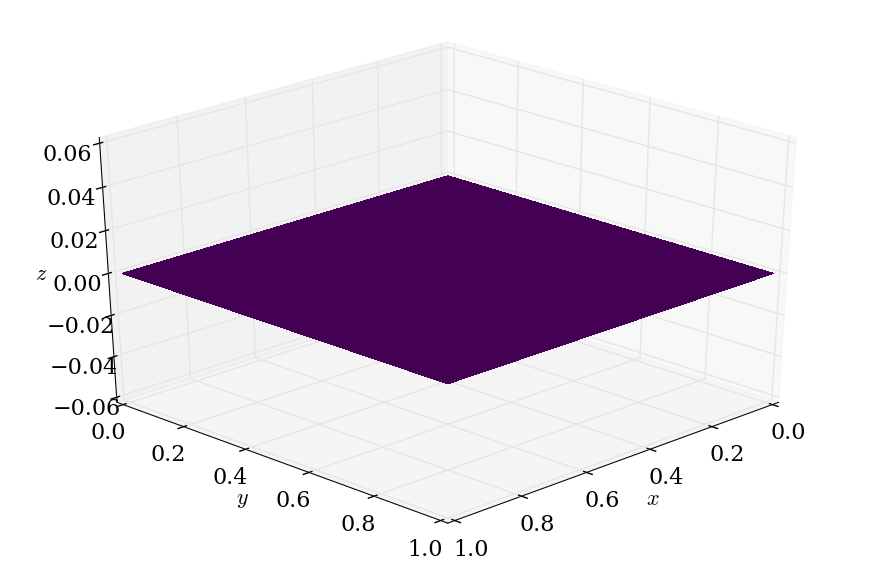

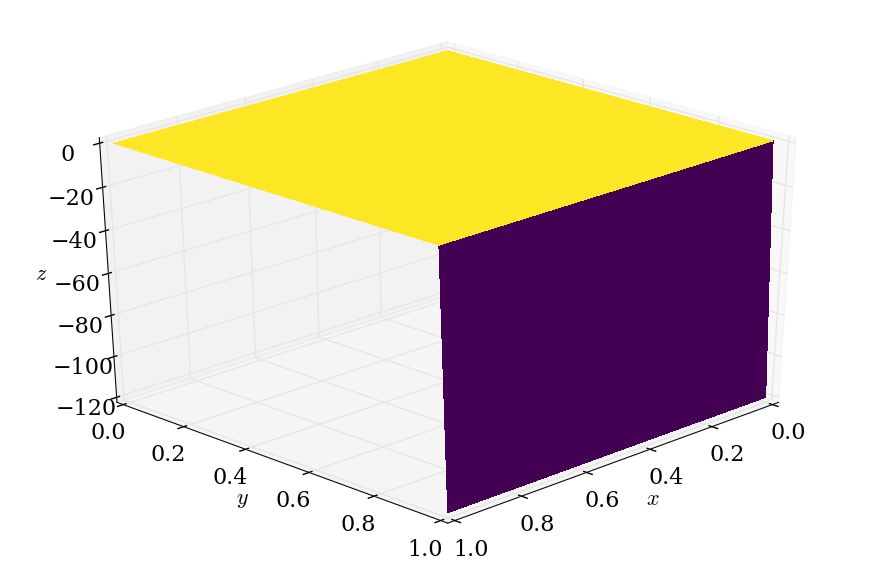

In [5]:
plot_3D(x,y,P)
plot_3D(x,y,O)

Le résultat affiché est bien cohérent avec les conditions initiales que nous donnons : $\psi$ nul partout et $\omega$ nul partout sauf sur un bord où sa valeur est 1.

Maintenant, créons une fonction qui ittérera la méthode de Jacobi jusqu'à ce que le critère en norme L1 défini plus haut soit atteint. Nous devrons calculer successivement les valeurs de $\omega$ influencées par les conditions au bords et en tirer des valeurs de $\psi$. Cet algorithme est grandement inspiré de ceux présentés dans les notebooks pour la méthode de Jacobi.

In [6]:
def laplace2d(O, P, dx, dy, l1_target):
    
    Onorm = 1
    Pnorm = 1
    o = numpy.zeros((ny,nx))
    p = numpy.zeros((ny,nx))
    N = 0
    
    while Onorm > l1_target or Pnorm > l1_target: #On applique Jacobi tant qu'une des normes L1 est plus élevée que
                                                  #la valeur ciblée.
            
        o = O.copy()
        p = P.copy()
        
        O[1:-1,1:-1] = 0.25 * (o[1:-1,2:] + o[1:-1, :-2] + o[2:, 1:-1] + o[:-2, 1:-1]) #Jacobi tirée du notebook 1
    
        
        O[-1,:] = -0.5/(dy**2)*(8*P[-2,:]-P[-3,:])-(3/dy) #Implémentation des conditions aux bords
        O[0,:] = -0.5/(dy**2)*(8*P[1,:]-P[2,:])
        O[:,-1] = -0.5/(dy**2)*(8*P[:,-2]-P[:,-3])
        O[:,0] = -0.5/(dy**2)*(8*P[:,1]-P[:,2])
        
        P[1:-1,1:-1] = 0.25 * (p[1:-1,2:] + p[1:-1,:-2] + p[2:,1:-1] + p[:-2,1:-1] + O[1:-1,1:-1] * dx**2)
        
        Onorm  = L1norm(O,o)
        Pnorm = L1norm(P,p)
        N = N+1

    return O, P, N

NB : remarquons que les conditions aux bords n'étant pas continues par le passage d'un bord a l'autre, l'ordre d'implémentation de celles-ci est important! l'énoncé n'étant pas réellement explicite par rapport aux conditions aux bords sur les coins, nous avons simplement choisi comme ordre celui qui vérifiera les questions posées a la fin du module.

Nous pouvons directement voir ce que nous renvoie cette fonction en l'appliquant et en la dessin avec notre fonction plot_3D.

In [7]:
O, P, N = laplace2d(O.copy(), P.copy(), dx, dy, l1_target)

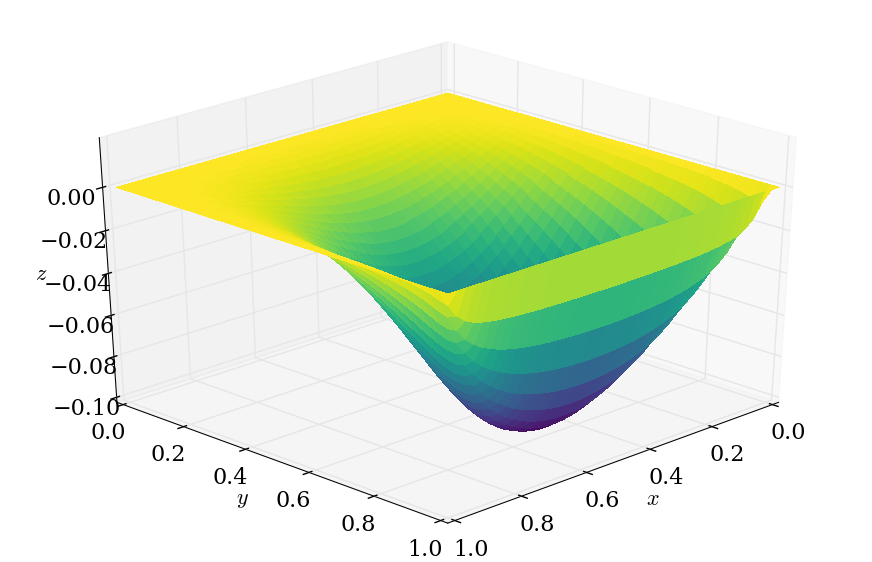

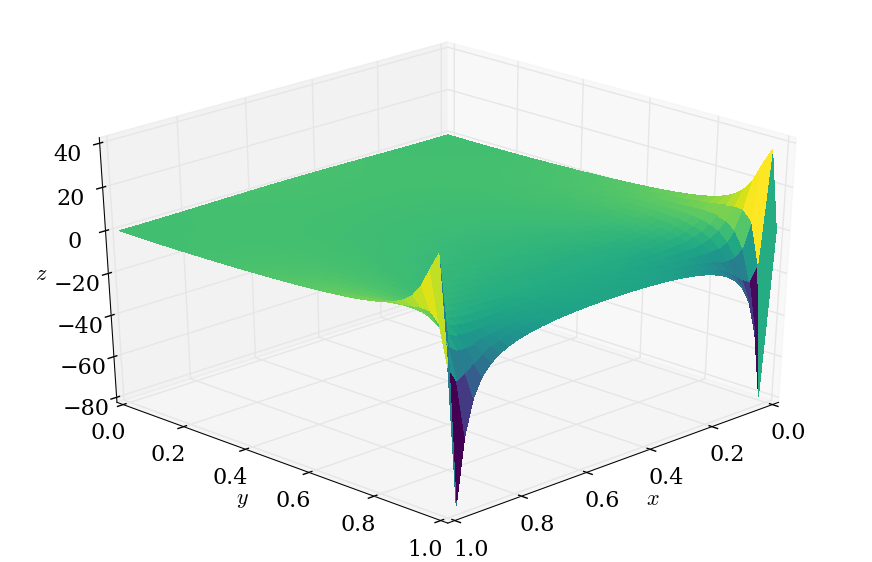

In [8]:
plot_3D(x,y,P)
plot_3D(x,y,O)

Vérifions donc la véracité de notre raisonnement en répondant aux questions du Module 5 :

In [9]:
print("La valeur maximale de |P| dans la cavité est",numpy.max(numpy.abs(P))) #P pour psi
print("La valeur maximale de |O| dans la cavité est",numpy.max(numpy.abs(O))) #O pour omega
numpy.round(P[32,::8],4)

La valeur maximale de |P| dans la cavité est 0.0998451724383
La valeur maximale de |O| dans la cavité est 78.1926612286


array([ 0.    , -0.0575, -0.0944, -0.0944, -0.0575,  0.    ])

Toutes ces réponses sont confirmées dans le "graded assessment".

Notons que la méthode de Jacobi n'est pas décrite comme étant la meilleure pour résoudre ce genre d'équations stationnaires (comme nous l'avons vu dans les autres notebooks), mais dans l'exercice présent elle suffisait amplement car les calculs demandés n'étaient pas extrêmement longs.

Jetons un oeuil au nombre d'ittérations nécessaires à la résolution de l'algorithme 

In [10]:
print("Le nombre d'ittérations nécessaires par Jacobi est :",N)

Le nombre d'ittérations nécessaires par Jacobi est : 4059


La méthode requiert donc un nombre important d'itérations, là où d'autres méthodes qui nous ont été présentées (telle que la méthode "conjugate gradients") auraient pu significativement le réduire.

Et ainsi par une méthode simple nous avons pu, grâce au modèle de l'écoulement de Stokes, réduire l'équation de Navier Stokes à un problème aisément résolvable dans le cadre d'une analyse numérique